<a id="top"></a> 
Contents:
1. [Data loading](#01)
1. [Trip visualisation](#02)
1. [Pricing per mode of transport](#03)
1. [Route analysis](#04)
1. [Ticket buying habits](#05)
1. [Route pricing analysis](#06)
1. [Travel distance analysis](#07)
1. [Predictions](#08)



<a id="01"></a> 
# Data loading
[back to top](#top)	

In [1]:
import pandas as pd
import numpy as np
import scipy
import os

ticket_data.csv : Contenant un historique de ticket (une ligne => une proposition de ticket sur tictactrip)  
cities.csv les villes desservies par tictactrip (lien grâce aux colonnes o_city (origin_city), d_city (destination_city) de ticket_data)   
stations.csv les stations desservies par tictactrip (lien via o_station, d_station de ticket_data)   
providers.csv infos sur les différents providers (lien via company de ticket_data)Un provider est une "sous-compagnie". Par exemple TGV et TER sont deux providers de VSC (voyages-sncf).  



In [2]:
import ipynbname
nb_fname = ipynbname.name()

In [3]:
notebook_path = os.path.abspath(nb_fname+'.ipynb')
ticket_data_path = os.path.join(os.path.dirname(notebook_path), "Datasets/ticket_data.csv")
ticket_df = pd.read_csv(ticket_data_path)

In [4]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               74168 non-null  int64  
 1   company          74168 non-null  int64  
 2   o_station        32727 non-null  float64
 3   d_station        32727 non-null  float64
 4   departure_ts     74168 non-null  object 
 5   arrival_ts       74168 non-null  object 
 6   price_in_cents   74168 non-null  int64  
 7   search_ts        74168 non-null  object 
 8   middle_stations  32727 non-null  object 
 9   other_companies  32727 non-null  object 
 10  o_city           74168 non-null  int64  
 11  d_city           74168 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 6.8+ MB


In [5]:
ticket_df['departure_ts'] = pd.to_datetime(ticket_df['departure_ts'])
ticket_df['arrival_ts'] = pd.to_datetime(ticket_df['arrival_ts'])
ticket_df = ticket_df[ticket_df['search_ts'].notna()].copy()
ticket_df['search_ts'] = pd.to_datetime(ticket_df['search_ts'], format ='mixed')

In [6]:
ticket_df.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,542


In [7]:
ticket_df['duration'] = ticket_df['arrival_ts'] - ticket_df['departure_ts']
ticket_df['duration (h)'] = (ticket_df['duration'] - ticket_df['duration'].dt.floor('D')) / pd.Timedelta(hours=1)
ticket_df['duration (min)'] = ticket_df['duration'] / pd.Timedelta(minutes=1)

In [8]:
ticket_df.describe()

,id,company,o_station,d_station,price_in_cents,o_city,d_city,duration,duration (h),duration (min)
count,7.416800e+04,74168.000000,32727.000000,32727.000000,74168.000000,74168.000000,74168.000000,74168,74168.000000,74168.000000
mean,6.832108e+06,7109.565527,2907.132673,2347.858129,4382.711061,849.186105,883.776265,0 days 07:04:37.247600043,6.015315,424.620793
std,2.141060e+04,3005.380792,3347.629180,3090.798007,3739.325367,1485.791782,1654.698575,0 days 09:54:58.881351022,4.500198,594.981356
min,6.795025e+06,9.000000,3.000000,3.000000,300.000000,5.000000,1.000000,0 days 00:20:00,0.000000,20.000000
25%,6.813567e+06,8376.000000,400.000000,396.000000,1900.000000,485.000000,453.000000,0 days 03:00:00,2.833333,180.000000
50%,6.832108e+06,8385.000000,701.000000,575.000000,3350.000000,628.000000,562.000000,0 days 04:50:00,4.816667,290.000000
75%,6.850650e+06,8385.000000,6246.000000,4538.000000,5250.000000,628.000000,628.000000,0 days 08:00:00,7.416667,480.000000
max,6.869192e+06,8387.000000,11017.000000,11017.000000,38550.000000,12190.000000,12190.000000,20 days 12:51:00,23.966667,29571.000000


In [9]:
cities_path = os.path.join(os.path.dirname(notebook_path), "Datasets/cities.csv")
cities_df = pd.read_csv(cities_path)

In [10]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8040 non-null   int64  
 1   local_name   8040 non-null   object 
 2   unique_name  8039 non-null   object 
 3   latitude     8040 non-null   float64
 4   longitude    8040 non-null   float64
 5   population   369 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 377.0+ KB


In [11]:
cities_df.head()

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [12]:
providers_path = os.path.join(os.path.dirname(notebook_path), "Datasets/providers.csv")
providers_df = pd.read_csv(providers_path)

In [13]:
providers_df.head()

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus


In [14]:
providers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    227 non-null    int64 
 1   company_id            227 non-null    int64 
 2   provider_id           213 non-null    object
 3   name                  227 non-null    object
 4   fullname              227 non-null    object
 5   has_wifi              224 non-null    object
 6   has_plug              224 non-null    object
 7   has_adjustable_seats  224 non-null    object
 8   has_bicycle           224 non-null    object
 9   transport_type        227 non-null    object
dtypes: int64(2), object(8)
memory usage: 17.9+ KB


<a id="02"></a> 
# Trip visualisation
[back to top](#top)	

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [16]:
try:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
except:
    print('Failed to fetch map data from remote')
    map_path = os.path.join(os.path.dirname(notebook_path), "Maps/naturalearth_lowres.shp")
    world = gpd.read_file(map_path)

C:\Users\arvyd\AppData\Local\Temp/ipykernel_21848/1816442435.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [17]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [18]:
eu = world.loc[world['continent'] == 'Europe']
#Supprimer Russia et Iceland
eu=eu[(eu.name!='Russia') & (eu.name!='Iceland')]

In [19]:
#Créer un filtre personnalisé
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
#Clip filtre de la carte de l'Europe
eu=gpd.clip(eu, polygon) 

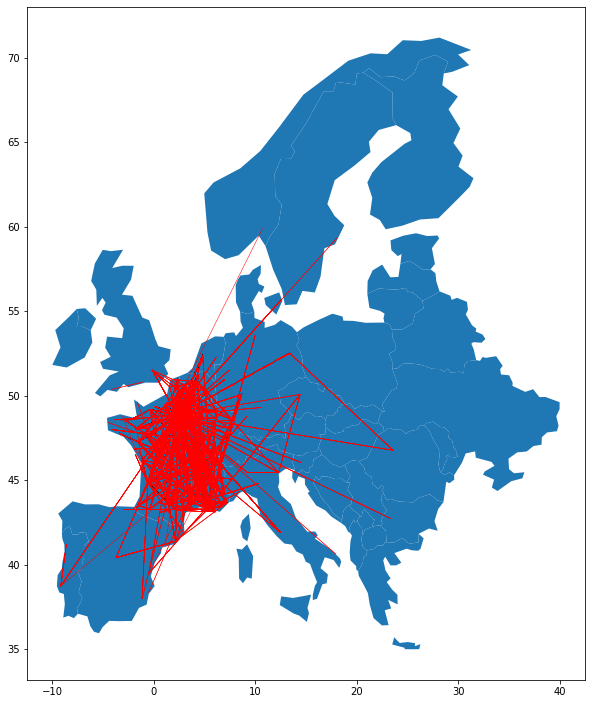

In [20]:
fig, ax = plt.subplots(figsize = (10,14))
ax.set_aspect('equal')
eu.plot(ax= ax)
for ind in ticket_df.index:
    o_city = ticket_df.loc[ind]['o_city']
    d_city = ticket_df.loc[ind]['d_city']
    route = cities_df.loc[(cities_df['id'] == o_city) | (cities_df['id'] == d_city)]
    ax.plot(list(route['longitude']),list(route['latitude']), 'ro-', linewidth=0.5, markersize=0)
    if ind == 10000:
        break

In [21]:
cities_df['country'] = cities_df['local_name'].apply(lambda x: x.split(', ')[-1])
cities_df['city'] = cities_df['local_name'].apply(lambda x: x.split(', ')[0])

In [22]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8040 non-null   int64  
 1   local_name   8040 non-null   object 
 2   unique_name  8039 non-null   object 
 3   latitude     8040 non-null   float64
 4   longitude    8040 non-null   float64
 5   population   369 non-null    float64
 6   country      8040 non-null   object 
 7   city         8040 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 502.6+ KB


In [23]:
df_directions = ticket_df.merge(providers_df[['id', 'transport_type']], left_on='company', right_on='id')
df_directions.drop('id_y', axis=1, inplace=True) 
df_directions.rename(columns={'id_x': 'id'}, inplace=True)
df_directions = pd.merge(df_directions, cities_df[['id', 'country']], left_on='o_city', right_on='id')
df_directions.drop('id_y', axis=1, inplace=True) 
df_directions.rename(columns={'id_x': 'id', 'country':'o_country'}, inplace=True)
df_directions = pd.merge(df_directions, cities_df[['id', 'country']], left_on='d_city', right_on='id')
df_directions.drop('id_y', axis=1, inplace=True) 
df_directions.rename(columns={'id_x': 'id', 'country':'d_country'}, inplace=True)
df_directions['same_country'] = df_directions['o_country'] == df_directions['d_country']
df_directions['direct'] = df_directions['middle_stations'].isnull()

In [24]:
df_directions = pd.merge(df_directions, cities_df[['id', 'city']], left_on='o_city', right_on='id')
df_directions.drop('id_y', axis=1, inplace=True) 
df_directions.rename(columns={'id_x': 'id', 'o_city':'o_city_ind', 'city': 'o_city'}, inplace=True)
df_directions = pd.merge(df_directions, cities_df[['id', 'city']], left_on='d_city', right_on='id')
df_directions.drop('id_y', axis=1, inplace=True) 
df_directions.rename(columns={'id_x': 'id', 'd_city':'d_city_ind', 'city':'d_city'}, inplace=True)

In [25]:
df_directions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               74168 non-null  int64              
 1   company          74168 non-null  int64              
 2   o_station        32727 non-null  float64            
 3   d_station        32727 non-null  float64            
 4   departure_ts     74168 non-null  datetime64[ns, UTC]
 5   arrival_ts       74168 non-null  datetime64[ns, UTC]
 6   price_in_cents   74168 non-null  int64              
 7   search_ts        74168 non-null  datetime64[ns, UTC]
 8   middle_stations  32727 non-null  object             
 9   other_companies  32727 non-null  object             
 10  o_city_ind       74168 non-null  int64              
 11  d_city_ind       74168 non-null  int64              
 12  duration         74168 non-null  timedelta64[ns]    
 13  duration (h)    

In [26]:
#plot n trips with most intermediate stops
df_trips_with_stops = df_directions.copy(deep=True)
df_trips_with_stops = df_trips_with_stops[df_trips_with_stops['direct'] == False]
df_trips_with_stops['n_stops'] = (df_trips_with_stops['middle_stations'].str.count(',') + 1).sort_values(ascending = False)
df_trips_with_stops.sort_values('n_stops', ascending=False);


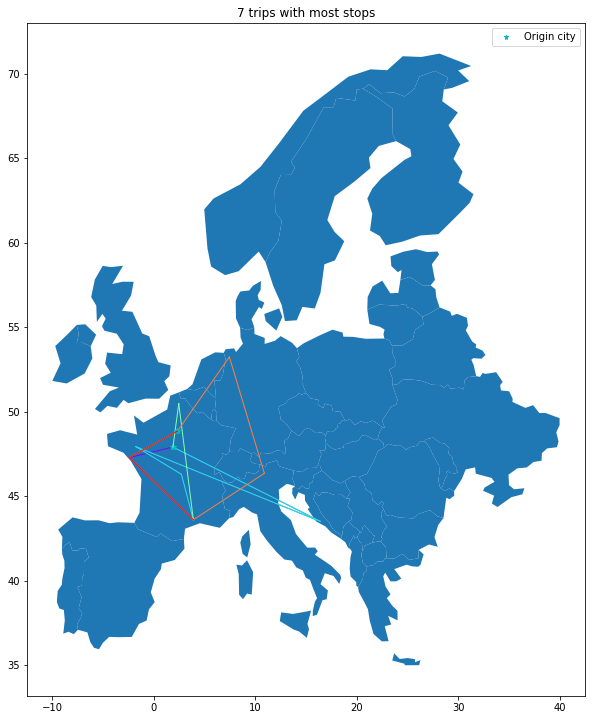

In [27]:
#now plot top 7 trips
fig, ax = plt.subplots(figsize = (10,14))
ax.set_aspect('equal')
eu.plot(ax = ax)
n_trips = 7
colors = cm.rainbow(np.linspace(0, 1, n_trips))
for i in range(n_trips):
    col = colors[i]
    #print(df_trips_with_stops.iloc[i])
    o_stop = df_trips_with_stops.iloc[i]['o_city_ind']
    d_stop = df_trips_with_stops.iloc[i]['d_city_ind']
    ax.plot(cities_df[(cities_df['id'] == o_stop)]['longitude'].values,
            cities_df[(cities_df['id'] == o_stop)]['latitude'].values, 'c*')
    for stop in [int(x) for x in df_trips_with_stops.iloc[i]['middle_stations'][1:-1].split(',')]:
        route = cities_df.loc[(cities_df['id'] == o_stop) | (cities_df['id'] == stop)]
        if len(route.index) >1:
            ax.plot(list(route['longitude']),list(route['latitude']),
                    color = col, linestyle = '-', linewidth=1, markersize=0)
            o_stop = stop
        
    route = cities_df.loc[(cities_df['id'] == o_stop) | (cities_df['id'] == d_stop)]
    ax.plot(list(route['longitude']),list(route['latitude']), color = col, linestyle = '-', linewidth=1, markersize=0)

point = Line2D([0], [0], label='Origin city', marker='*', markersize=5, 
         markeredgecolor='c', markerfacecolor='c', linestyle='')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([point])
plt.legend(handles=handles)
plt.title(f'{n_trips} trips with most stops');


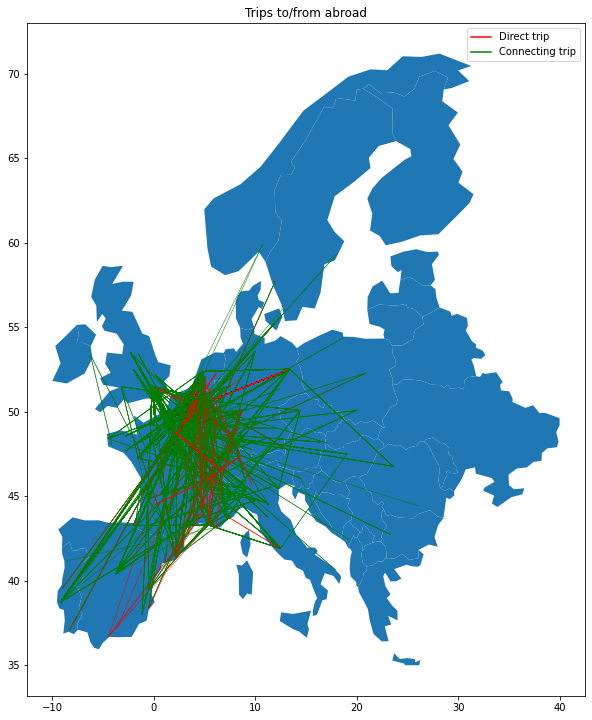

In [28]:
fig, ax = plt.subplots(figsize = (10,14))
ax.set_aspect('equal')
eu.plot(ax = ax)
for ind in df_directions[df_directions['same_country'] == False].index:
    col = 'red'
    if df_directions.loc[ind]['direct']:
        col = 'red'
    else:
        col = 'green'
    o_city = df_directions.loc[ind]['o_city_ind']
    d_city = df_directions.loc[ind]['d_city_ind']
    route = cities_df.loc[(cities_df['id'] == o_city) | (cities_df['id'] == d_city)]
    ax.plot(list(route['longitude']),list(route['latitude']), color = col, linestyle = '-', linewidth=0.5, markersize=0)
lines = [Line2D([0], [0], color='red'), Line2D([0], [0], color='green')]
labels = ['Direct trip', 'Connecting trip']
plt.legend(lines, labels)
plt.title('Trips to/from abroad');

<a id="03"></a> 
# Pricing per mode of transport
[back to top](#top)	

In [29]:
import seaborn as sns

In [30]:
df_merged = ticket_df.merge(providers_df[['id', 'transport_type']], left_on='company', right_on='id')
df_merged.drop('id_y', axis=1, inplace=True) 
df_merged.rename(columns={'id_x': 'id'}, inplace=True)
df_merged.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,duration (h),duration (min),transport_type
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542,0 days 06:10:00,6.166667,370.0,carpooling
1,6795030,8385,NaN,NaN,2017-10-06 05:30:00+00:00,2017-10-06 08:30:00+00:00,1800,2017-10-01 01:03:18.948000+00:00,NaN,NaN,628,453,0 days 03:00:00,3.000000,180.0,carpooling
2,6795031,8385,NaN,NaN,2017-10-06 07:00:42+00:00,2017-10-06 09:30:42+00:00,2150,2017-10-01 01:03:18.948000+00:00,NaN,NaN,628,453,0 days 02:30:00,2.500000,150.0,carpooling
3,6795032,8385,NaN,NaN,2017-10-06 07:10:00+00:00,2017-10-06 09:40:00+00:00,1700,2017-10-01 01:03:18.948000+00:00,NaN,NaN,628,453,0 days 02:30:00,2.500000,150.0,carpooling
4,6795033,8385,NaN,NaN,2017-10-06 10:00:00+00:00,2017-10-06 12:50:00+00:00,1700,2017-10-01 01:03:18.948000+00:00,NaN,NaN,628,453,0 days 02:50:00,2.833333,170.0,carpooling


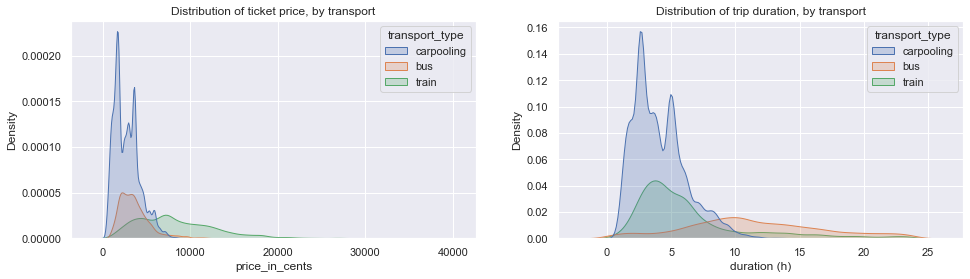

In [31]:
sns.set()
#define plotting region (1 rows, 2 columns)
fig, axes = plt.subplots(1, 2, figsize = (16,4))
sns.kdeplot(data=df_merged, x='price_in_cents', hue='transport_type', fill=True, ax=axes[0])
sns.kdeplot(data=df_merged, x='duration (h)', hue='transport_type', fill=True, ax=axes[1]);
axes[0].set_title("Distribution of ticket price, by transport")
axes[1].set_title("Distribution of trip duration, by transport");

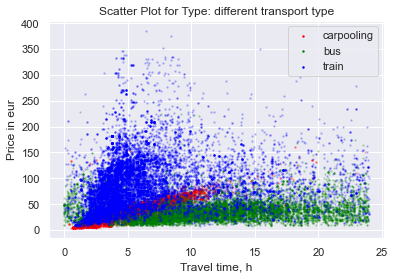

In [32]:
fig, ax = plt.subplots()
colors = ['red', 'green', 'blue']
# Iterate through unique values in the 'type' column
for type_value, color in zip(df_merged['transport_type'].unique(), colors):
  # Filter data for current type
  df_filtered = df_merged[df_merged['transport_type'] == type_value]
  ax.scatter(df_filtered['duration (h)'], df_filtered['price_in_cents']/100, label=type_value, c=color, alpha = 0.2, s = 2)
ax.set_xlabel('Travel time, h')
ax.set_ylabel('Price in eur')
ax.set_title(f'Scatter Plot for Type: different transport type')
leg = plt.legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)
plt.show()  # Display the plot

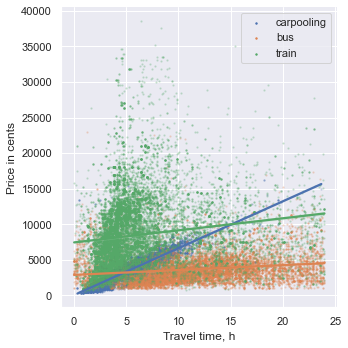

In [33]:
plot = sns.lmplot(x="duration (h)", y="price_in_cents", hue="transport_type", data=df_merged, scatter_kws={"s": 2, "alpha" : 0.2}, legend = False)
plt.xlabel('Travel time, h')
plt.ylabel('Price in cents')
# Get legend handles and labels
handles, labels = plot.ax.get_legend_handles_labels()
leg = plot.ax.legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)

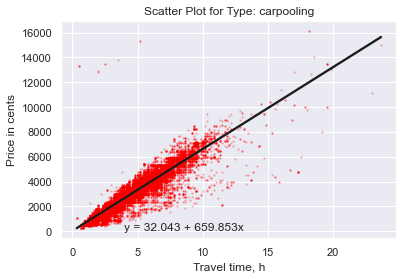

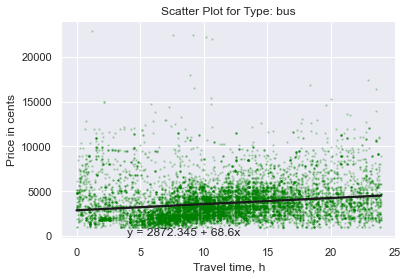

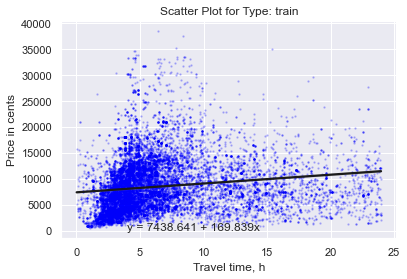

In [40]:
colors = ['red', 'green', 'blue']
# Iterate through unique values in the 'type' column
for type_value, color in zip(df_merged['transport_type'].unique(), colors):
    # Filter data for current type
    df_filtered = df_merged[df_merged['transport_type'] == type_value]

    plt.figure()  # Create a new figure for each type
    plot = sns.regplot(x=df_filtered['duration (h)'], y=df_filtered['price_in_cents'], color=color
                       ,scatter_kws={"s": 2, "alpha" : 0.2}, line_kws = {"color" : 'k'}
                      )
    #calculate slope and intercept of regression equation
    slope, intercept, r, p, sterr = scipy.stats.linregress(x=plot.get_lines()[0].get_xdata(),
                                                       y=plot.get_lines()[0].get_ydata())
    plt.xlabel('Travel time, h')
    plt.ylabel('Price in cents')
    plt.title(f'Scatter Plot for Type: {type_value}')
    plt.text(4, 95, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')
    plt.show()  # Display the plot

<a id="04"></a> 
# Route analysis
[back to top](#top)	

In [41]:
df_directions.sample(2)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,...,duration,duration (h),duration (min),transport_type,o_country,d_country,same_country,direct,o_city,d_city
30986,6810701,8385,NaN,NaN,2017-10-06 18:00:00+00:00,2017-10-06 20:50:00+00:00,1550,2017-10-05 17:05:01.540000+00:00,NaN,NaN,...,0 days 02:50:00,2.833333,170.0,carpooling,France,France,True,True,Paris,Lille
7323,6803845,8385,NaN,NaN,2017-10-06 16:00:00+00:00,2017-10-06 20:40:00+00:00,3250,2017-10-04 08:13:41.650000+00:00,NaN,NaN,...,0 days 04:40:00,4.666667,280.0,carpooling,France,France,True,True,Clermont-Ferrand,Paris


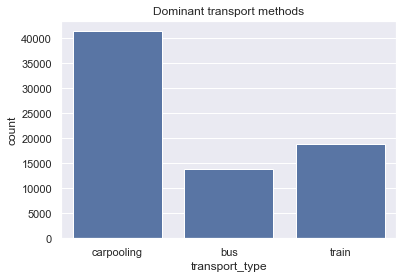

In [42]:
ax = sns.countplot(x="transport_type", data=df_merged)
ax.set_title('Dominant transport methods');

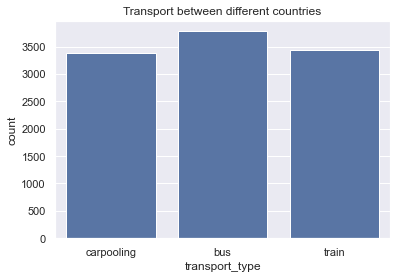

In [43]:
ax = sns.countplot(x="transport_type", data = df_directions[df_directions['same_country'] == False])
ax.set_title('Transport between different countries');

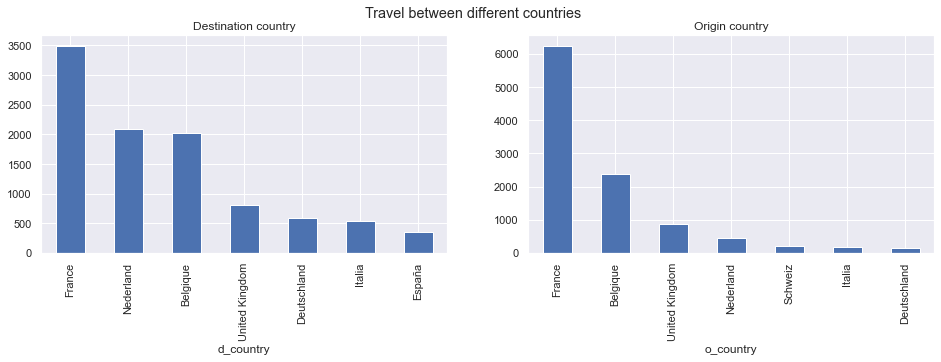

In [44]:
sns.set()

#define plotting region (1 rows, 2 columns)
fig, axes = plt.subplots(1, 2, figsize = (16,4))
fig.suptitle('Travel between different countries')
df_directions[df_directions['same_country'] == False]['d_country'].value_counts().nlargest(7).plot(kind='bar',
                                                                                                   ax=axes[0], title = 'Destination country')
df_directions[df_directions['same_country'] == False]['o_country'].value_counts().nlargest(7).plot(kind='bar',
                                                                                                   ax=axes[1], title = 'Origin country');

In [45]:
df_plot = df_directions[df_directions['same_country'] == False].groupby(['transport_type', 'd_country']).size().reset_index().pivot(columns='transport_type', index='d_country', values=0)
#df_plot.plot(kind='bar', stacked=True)

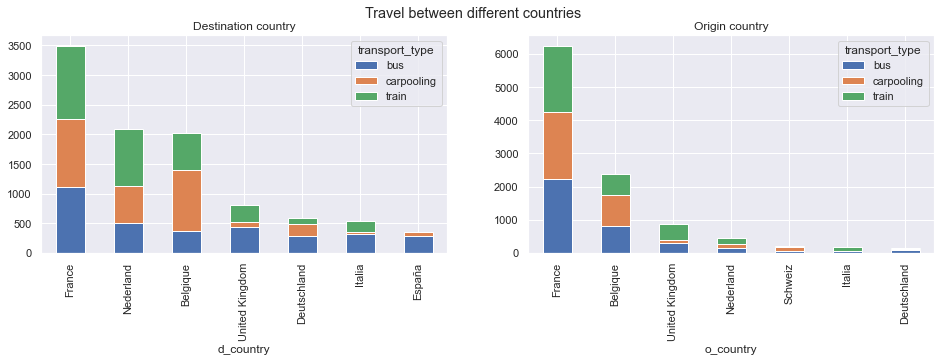

In [46]:
#set seaborn plotting aesthetics as default
sns.set()
fig, axes = plt.subplots(1, 2, figsize = (16,4))
fig.suptitle('Travel between different countries')
#Filter destination country
df_plot = df_directions[df_directions['same_country'] == False].groupby(['transport_type', 'd_country']).size().reset_index().pivot(columns='transport_type', index='d_country', values=0)
s = df_plot.sum(axis=1).sort_values(ascending=False).index[:7]
df_plot.loc[s].plot(kind='bar', stacked=True, ax=axes[0], title = 'Destination country')
#Filter origin country
df_plot = df_directions[df_directions['same_country'] == False].groupby(['transport_type', 'o_country']).size().reset_index().pivot(columns='transport_type', index='o_country', values=0)
s = df_plot.sum(axis=1).sort_values(ascending=False).index[:7]
df_plot.loc[s].plot(kind='bar', stacked=True, ax=axes[1], title = 'Origin country');

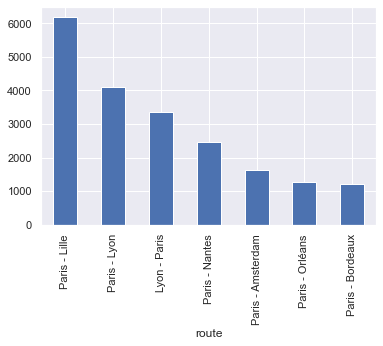

In [47]:
#whats the most common route
df_pop_trips = df_directions.copy(deep=True)
df_pop_trips['route'] = df_pop_trips['o_city'].astype(str)+' - '+df_pop_trips['d_city'].astype(str)
df_pop_trips.sample()['route']
df_pop_trips['route'].value_counts().nlargest(7).plot(kind='bar');

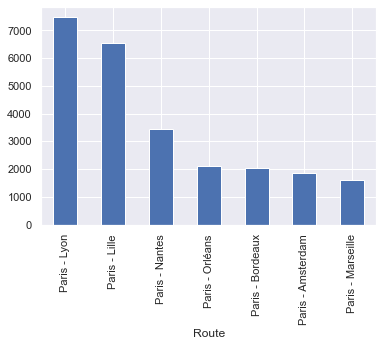

In [48]:
#fix that A to B and B to A is the same route
df_pop_trips = df_directions.copy(deep=True)
df_pop_trips['route'] = np.where(df_pop_trips['o_city_ind'] > df_pop_trips['d_city_ind']
                                     , df_pop_trips['o_city'].astype(str)+' - '+df_pop_trips['d_city'].astype(str)
                                     , df_pop_trips['d_city'].astype(str)+' - '+df_pop_trips['o_city'].astype(str))
df_pop_trips['route'].value_counts().nlargest(7).plot(kind='bar', xlabel = 'Route');

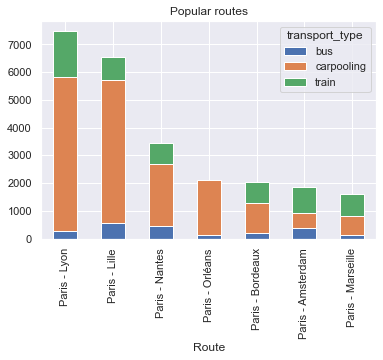

In [49]:
#which modes of transportation dominant on these routes
df_pop_trips_plot = df_pop_trips.copy(deep=True)
df_pop_trips_plot = df_pop_trips.groupby(['transport_type', 'route']).size().reset_index().pivot(columns='transport_type', index='route', values=0)
s = df_pop_trips_plot.sum(axis=1).sort_values(ascending=False).index[:7]
df_pop_trips_plot.loc[s].plot(kind='bar', stacked=True, title = 'Popular routes', xlabel = 'Route');

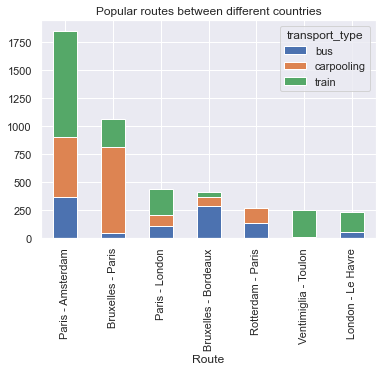

In [50]:
#which modes of transportation dominant on the most popular abroad routes
df_pop_trips_plot = df_pop_trips.loc[df_pop_trips['same_country'] == False]#.copy(deep=True)
df_pop_trips_plot = df_pop_trips_plot.groupby(['transport_type', 'route']).size().reset_index().pivot(columns='transport_type', index='route', values=0)
s = df_pop_trips_plot.sum(axis=1).sort_values(ascending=False).index[:7]
df_pop_trips_plot.loc[s].plot(kind='bar', stacked=True, title = 'Popular routes between different countries', xlabel = 'Route');

<a id="05"></a> 
# Ticket buying habits
[back to top](#top)	

In [51]:
#how much time before the trip ppl buy tickets
ticket_df_copy = ticket_df.copy(deep=True)
ticket_df_copy['time_before_trip'] = ticket_df_copy['departure_ts'] - ticket_df_copy['search_ts']
ticket_df_copy['time_before_trip (h)'] = ticket_df_copy['time_before_trip'] / pd.Timedelta(hours=1)
ticket_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   id                    74168 non-null  int64              
 1   company               74168 non-null  int64              
 2   o_station             32727 non-null  float64            
 3   d_station             32727 non-null  float64            
 4   departure_ts          74168 non-null  datetime64[ns, UTC]
 5   arrival_ts            74168 non-null  datetime64[ns, UTC]
 6   price_in_cents        74168 non-null  int64              
 7   search_ts             74168 non-null  datetime64[ns, UTC]
 8   middle_stations       32727 non-null  object             
 9   other_companies       32727 non-null  object             
 10  o_city                74168 non-null  int64              
 11  d_city                74168 non-null  int64              
 12  dura

count    74168.000000
mean       173.522923
std        253.953728
min       -575.683151
25%         47.027578
50%         99.002067
75%        203.017745
max       4233.222895
Name: time_before_trip (h), dtype: float64

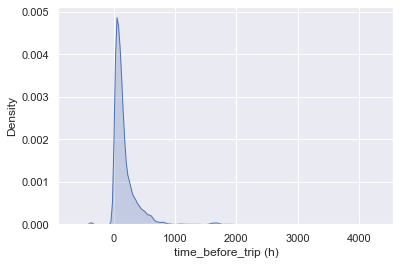

In [52]:
distr = sns.kdeplot(data=ticket_df_copy, x='time_before_trip (h)', fill=True);
ticket_df_copy['time_before_trip (h)'].describe()

In [53]:
#remove entries where ticket where purchased after the trip
ticket_df_copy = ticket_df_copy[ticket_df_copy['time_before_trip (h)'] > 0]

count    73910.000000
mean       175.429283
std        252.308237
min          1.959267
25%         47.383827
50%         99.343086
75%        204.408683
max       4233.222895
Name: time_before_trip (h), dtype: float64

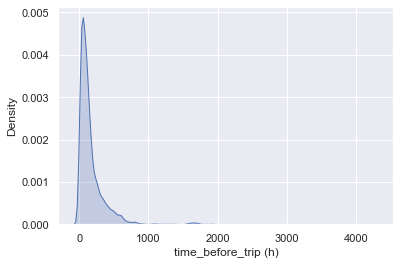

In [54]:
distr = sns.kdeplot(data=ticket_df_copy, x='time_before_trip (h)', fill=True);
ticket_df_copy['time_before_trip (h)'].describe()

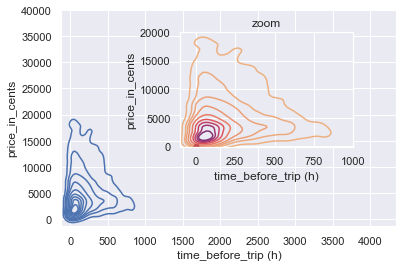

In [55]:
fig, ax = plt.subplots()
sns.kdeplot(x='time_before_trip (h)',y='price_in_cents', data = ticket_df_copy, ax= ax)

ax2 = plt.axes([0.4, 0.4, .4, .4])
sns.kdeplot(x='time_before_trip (h)',y='price_in_cents', data = ticket_df_copy, ax= ax2,  cmap = "flare")
ax2.set_title('zoom')
ax2.plot(0,0, 'ro', markersize = 5)
ax2.set_xlim([-100,1000])
ax2.set_ylim([-100,20000]);

<a id="06"></a> 
# Route pricing analysis
[back to top](#top)	

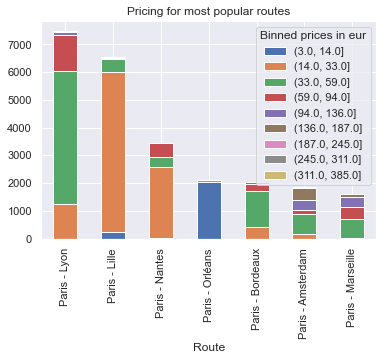

In [56]:
#price per route
df_trip_prices = df_pop_trips.copy(deep=True)
p_min, p_max = min(df_trip_prices['price_in_cents']/100), max(df_trip_prices['price_in_cents']/100)
n_bins = 10
#bins = np.linspace(p_min, p_max, n_bins)
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.round(np.power( np.linspace(start, stop, num=num), power),0)

bins = powspace(p_min, p_max, 2, n_bins) #more descriptive binning than linear

df_trip_prices['binned_price_in_eur'] = pd.cut(df_trip_prices['price_in_cents']/100, bins)
df_trip_prices_plot = df_trip_prices.groupby(['binned_price_in_eur', 'route']).size().reset_index().pivot(columns='binned_price_in_eur', index='route', values=0)

s = df_trip_prices_plot.sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot.loc[s].plot(kind='bar', stacked=True, title = 'Pricing for most popular routes', xlabel = 'Route');

plt.legend(title="Binned prices in eur");

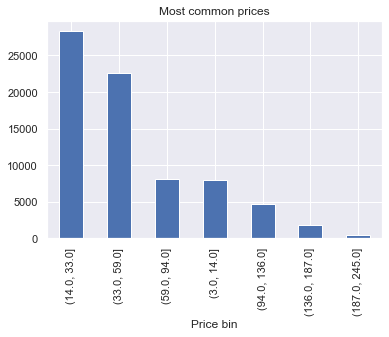

In [57]:
#prices distribution
df_trip_prices['binned_price_in_eur'].value_counts().nlargest(7).plot(kind='bar', xlabel = 'Price bin', title = 'Most common prices');

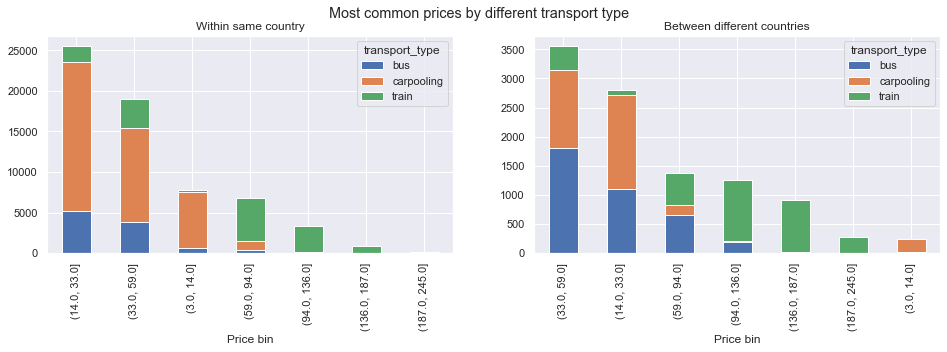

In [58]:
sns.set()
fig, axes = plt.subplots(1, 2, figsize = (16,4))
fig.suptitle('Most common prices by different transport type')

df_trip_prices_plot = df_trip_prices.loc[df_pop_trips['same_country'] == True]
df_trip_prices_plot = df_trip_prices_plot .groupby(['transport_type', 'binned_price_in_eur']).size().reset_index().pivot(columns='transport_type', index='binned_price_in_eur', values=0)
s = df_trip_prices_plot .sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot .loc[s].plot(kind='bar', stacked=True, ax=axes[0], title = 'Within same country', xlabel = 'Price bin');

df_trip_prices_plot = df_trip_prices.loc[df_pop_trips['same_country'] == False]
df_trip_prices_plot = df_trip_prices_plot .groupby(['transport_type', 'binned_price_in_eur']).size().reset_index().pivot(columns='transport_type', index='binned_price_in_eur', values=0)
s = df_trip_prices_plot .sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot.loc[s].plot(kind='bar', stacked=True, ax=axes[1], title = 'Between different countries', xlabel = 'Price bin');

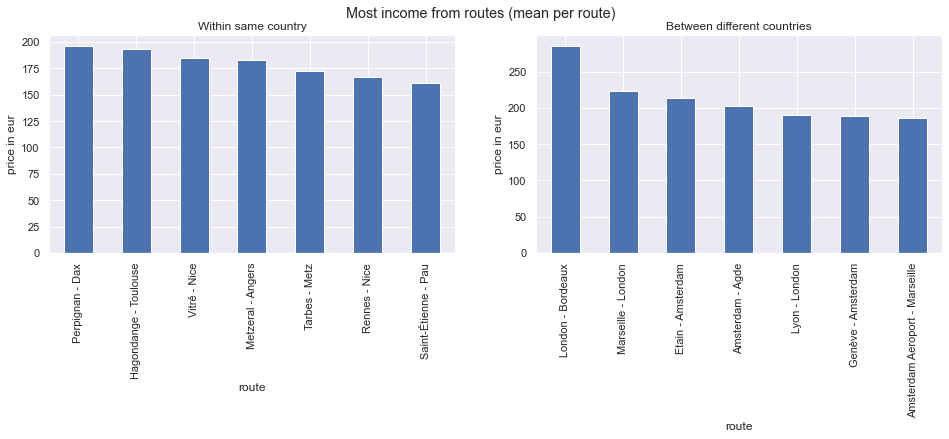

In [59]:
#most profitable route per trip
sns.set()
fig, axes = plt.subplots(1, 2, figsize = (16,4))
fig.suptitle('Most income from routes (mean per route)')

df = df_trip_prices[df_trip_prices['same_country'] == True][['price_in_cents', 'route']]
average_prices_by_route = df.groupby('route')['price_in_cents'].mean().sort_values(ascending=False)/100
average_prices_by_route[:7].plot(kind='bar', ax= axes[0], title = 'Within same country', ylabel = 'price in eur')

df = df_trip_prices[df_trip_prices['same_country'] == False][['price_in_cents', 'route']]
average_prices_by_route = df.groupby('route')['price_in_cents'].mean().sort_values(ascending=False) /100
average_prices_by_route[:7].plot(kind='bar', ax= axes[1], title = 'Between different countries', ylabel = 'price in eur');

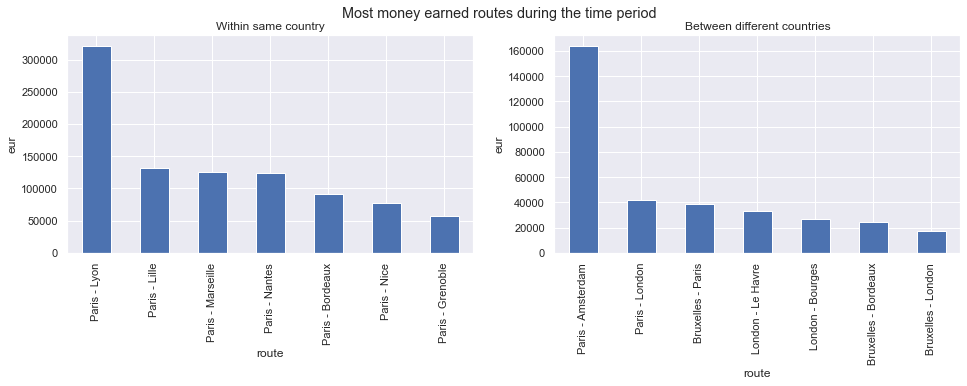

In [60]:
#Routes which made the most money
sns.set()
fig, axes = plt.subplots(1, 2, figsize = (16,4))
fig.suptitle('Most money earned routes during the time period')

df = df_trip_prices[df_trip_prices['same_country'] == True][['price_in_cents', 'route']]
average_prices_by_route = df.groupby('route')['price_in_cents'].sum().sort_values(ascending=False)/100
average_prices_by_route[:7].plot(kind='bar', ax= axes[0], title = 'Within same country', ylabel = 'eur')

df = df_trip_prices[df_trip_prices['same_country'] == False][['price_in_cents', 'route']]
average_prices_by_route = df.groupby('route')['price_in_cents'].sum().sort_values(ascending=False)/100
average_prices_by_route[:7].plot(kind='bar', ax= axes[1], title = 'Between different countries', ylabel = 'eur');

In [61]:
#day of the week analysis
df_trip_prices['trip_week_day'] = df_trip_prices['departure_ts'].dt.day_of_week
df_trip_prices = df_trip_prices[df_trip_prices['search_ts'].notna()].copy()
df_trip_prices['search_week_day'] = df_trip_prices['search_ts'].dt.day_of_week
df_trip_prices['trip_week_day'] = df_trip_prices['trip_week_day'] +1 
df_trip_prices['search_week_day'] = df_trip_prices['search_week_day'] +1 

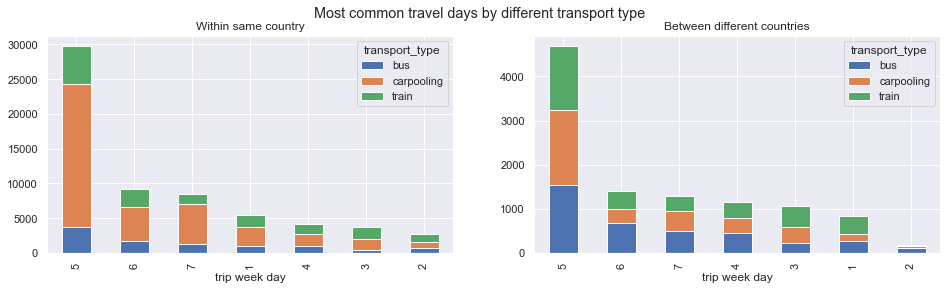

In [62]:
sns.set()
fig, axes = plt.subplots(1, 2, figsize = (16,4))
fig.suptitle('Most common travel days by different transport type')

df_trip_prices_plot = df_trip_prices.loc[df_trip_prices['same_country'] == True]
df_trip_prices_plot = df_trip_prices_plot .groupby(['transport_type', 'trip_week_day']).size().reset_index().pivot(columns='transport_type', index='trip_week_day', values=0)
s = df_trip_prices_plot .sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot .loc[s].plot(kind='bar', stacked=True, ax=axes[0], title = 'Within same country', xlabel = 'trip week day');

df_trip_prices_plot = df_trip_prices.loc[df_trip_prices['same_country'] == False]
df_trip_prices_plot = df_trip_prices_plot .groupby(['transport_type', 'trip_week_day']).size().reset_index().pivot(columns='transport_type', index='trip_week_day', values=0)
s = df_trip_prices_plot .sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot.loc[s].plot(kind='bar', stacked=True, ax=axes[1], title = 'Between different countries', xlabel = 'trip week day');

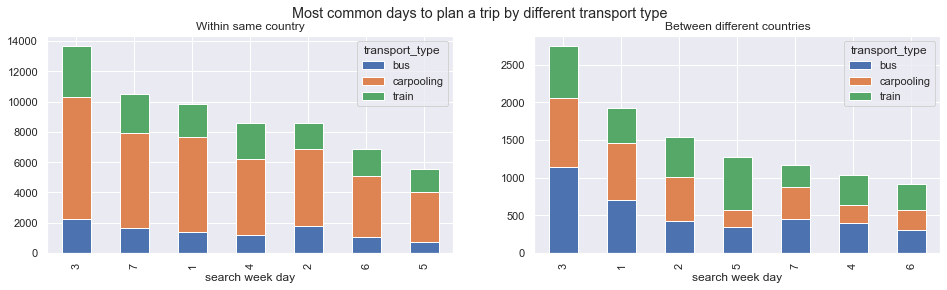

In [63]:
sns.set()
fig, axes = plt.subplots(1, 2, figsize = (16,4))
fig.suptitle('Most common days to plan a trip by different transport type')

df_trip_prices_plot = df_trip_prices.loc[df_trip_prices['same_country'] == True]
df_trip_prices_plot = df_trip_prices_plot .groupby(['transport_type', 'search_week_day']).size().reset_index().pivot(columns='transport_type', index='search_week_day', values=0)
s = df_trip_prices_plot .sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot .loc[s].plot(kind='bar', stacked=True, ax=axes[0], title = 'Within same country', xlabel = 'search week day');

df_trip_prices_plot = df_trip_prices.loc[df_trip_prices['same_country'] == False]
df_trip_prices_plot = df_trip_prices_plot .groupby(['transport_type', 'search_week_day']).size().reset_index().pivot(columns='transport_type', index='search_week_day', values=0)
s = df_trip_prices_plot .sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot.loc[s].plot(kind='bar', stacked=True, ax=axes[1], title = 'Between different countries', xlabel = 'search week day');

<a id="07"></a> 
# Travel distance analysis
[back to top](#top)	

In [67]:
#According to travel distance
import geopy.distance

def get_distance(row):
    if row['direct']:
        coords_1 = (cities_df[(cities_df['id'] == row['o_city_ind'])]['latitude'].iat[0],
                    cities_df[(cities_df['id'] == row['o_city_ind'])]['longitude'].iat[0])
        coords_2 = (cities_df[(cities_df['id'] == row['d_city_ind'])]['latitude'].iat[0],
                    cities_df[(cities_df['id'] == row['d_city_ind'])]['longitude'].iat[0])
        val = geopy.distance.geodesic(coords_1, coords_2).km
    else:
        val = 0
        coords_o = (cities_df[(cities_df['id'] == row['o_city_ind'])]['latitude'].iat[0],
                    cities_df[(cities_df['id'] == row['o_city_ind'])]['longitude'].iat[0])
        coords_d = (cities_df[(cities_df['id'] == row['d_city_ind'])]['latitude'].iat[0],
                    cities_df[(cities_df['id'] == row['d_city_ind'])]['longitude'].iat[0])
        for stop in [int(x) for x in row['middle_stations'][1:-1].split(',')]:
            try:
                coords_stop = (cities_df[(cities_df['id'] == stop)]['latitude'].iat[0],
                            cities_df[(cities_df['id'] == stop)]['longitude'].iat[0])
                val = val + geopy.distance.geodesic(coords_o, coords_stop).km
                coords_o = coords_stop
            except IndexError:
                pass
        val = val + geopy.distance.geodesic(coords_o, coords_d).km
    return round(val,0)
df_trip_prices['distance (km)'] = df_trip_prices.apply(get_distance, axis=1)
#lets bin the distances
p_min, p_max = min(df_trip_prices['distance (km)']), max(df_trip_prices['distance (km)'])
n_bins = 10
#bins = np.linspace(p_min, p_max, n_bins)
bins = powspace(p_min, p_max, 2, n_bins) #more descriptive binning than linear

df_trip_prices['binned distance (km)'] = pd.cut(df_trip_prices['distance (km)'], bins)

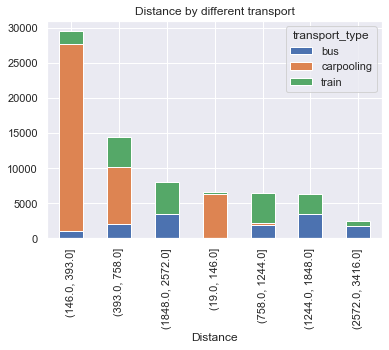

In [68]:
#distance distribution
#df_trip_prices['binned distance (km)'].value_counts().nlargest(7).plot(kind='bar', xlabel = 'Distance', title = 'Most common travelled sitances');
df_trip_prices_plot = df_trip_prices.groupby(['transport_type', 'binned distance (km)']).size().reset_index().pivot(columns='transport_type', index='binned distance (km)', values=0)

s = df_trip_prices_plot.sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot.loc[s].plot(kind='bar', stacked=True, title = 'Distance by different transport', xlabel = 'Distance');

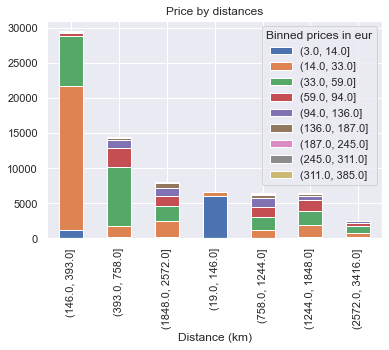

In [69]:
#how about distance and price
df_trip_prices_plot = df_trip_prices.groupby(['binned_price_in_eur', 'binned distance (km)']).size().reset_index().pivot(columns='binned_price_in_eur', index='binned distance (km)', values=0)

s = df_trip_prices_plot.sum(axis=1).sort_values(ascending=False).index[:7]
df_trip_prices_plot.loc[s].plot(kind='bar', stacked=True, title = 'Price by distances', xlabel = 'Distance (km)');
plt.legend(title="Binned prices in eur");

In [70]:
print(f"Min distance: {min(df_trip_prices['distance (km)'])} km, Max distance: {max(df_trip_prices['distance (km)'])} km")
print(f"Min price: {min(df_trip_prices['price_in_cents'])/100} eur, Max price: {max(df_trip_prices['price_in_cents'])} eur")

Min distance: 19.0 km, Max distance: 5461.0 km
Min price: 3.0 eur, Max price: 38550 eur


<a id="08"></a> 
# Predictions
[back to top](#top)	

In [84]:
#Predictions
#price prediction
prediction_df = df_trip_prices.copy(deep=True)
prediction_df['departure (h)'] = prediction_df['departure_ts'].dt.hour
#prediction_df.info()

In [85]:
prediction_df = prediction_df.drop(columns=['binned_price_in_eur', 'id', 'middle_stations', 'other_companies',
                                            'direct', 'duration','arrival_ts','search_ts', 'departure_ts', 'route',
                                           'o_city','d_city', 'o_country','d_country', 'binned distance (km)'])
prediction_df.columns

Index(['company', 'o_station', 'd_station', 'price_in_cents', 'o_city_ind',
       'd_city_ind', 'duration (h)', 'duration (min)', 'transport_type',
       'same_country', 'trip_week_day', 'search_week_day', 'distance (km)',
       'departure (h)'],
      dtype='object')

In [86]:
prediction_df = prediction_df.dropna(axis=0)

In [87]:
#categorical variables
s = (prediction_df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['transport_type']


In [88]:
from sklearn.preprocessing import OneHotEncoder #for transport type
OHE_enc = OneHotEncoder()
trans_t_enc = OHE_enc.fit_transform(prediction_df[['transport_type']]).toarray()
trans_t_enc = pd.DataFrame(trans_t_enc,columns=['trans_type_1','trans_type_2'])
trans_t_enc.index = prediction_df.index
prediction_df = prediction_df.drop('transport_type', axis=1)
prediction_df = pd.concat([prediction_df, trans_t_enc], axis=1)

In [89]:
# Separate target from predictors
y = prediction_df['price_in_cents']
X = prediction_df.drop(['price_in_cents'], axis=1)

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches with RF regressor
def score_dataset_RFR(X_train, X_valid, y_train, y_valid, n_leafs):
    model = RandomForestRegressor(n_estimators=n_leafs, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [95]:
print("MAE Random Forest (simpliest approach):")
print(score_dataset_RFR(X_train, X_valid, y_train, y_valid, 100))

MAE Random Forest (simpliest approach):
688.350375702832


In [96]:
for max_leaf_nodes in [5, 50, 100, 1000]:
    mae = score_dataset_RFR(X_train, X_valid, y_train, y_valid, max_leaf_nodes)
    print(f'Max leaf nodes: {max_leaf_nodes}  \t\t Mean Absolute Error:  {mae}')

Max leaf nodes: 5  		 Mean Absolute Error:  779.7525871071222
Max leaf nodes: 50  		 Mean Absolute Error:  695.116319841334
Max leaf nodes: 100  		 Mean Absolute Error:  688.350375702832
Max leaf nodes: 1000  		 Mean Absolute Error:  682.2850476918071


In [ ]:
from xgboost import XGBRegressor

def score_dataset_XGBR(X_train, X_valid, y_train, y_valid, n_est = 500, lr = 0.05):
    model = XGBRegressor(n_estimators=n_est, learning_rate=lr, n_jobs=4,early_stopping_rounds=5)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

print("MAE XGBR (simpliest approach):")
print(score_dataset_XGBR(X_train, X_valid, y_train, y_valid, 100))

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = { 
    'n_estimators': [100,200,500],
    'learning_rate': [0.001, 0.05, 0.1]
}
xgbr_gs= GridSearchCV(estimator=XGBRegressor(), param_grid=grid, cv= 5)
xgbr_gs.fit(X_train, y_train)
xgbr_gs.best_params_
print("MAE XGBR (with optimised params):")
print(score_dataset_XGBR(X_train, X_valid, y_train, y_valid, xgbr_gs.best_params_['n_estimators'],
                         xgbr_gs.best_params_['learning_rate']))

In [ ]:
model = XGBRegressor(n_estimators=xgbr_gs.best_params_['n_estimators'], learning_rate = xgbr_gs.best_params_['learning_rate'],n_jobs=4,early_stopping_rounds=5)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)
preds = model.predict(X_valid)

In [ ]:
plt.figure()
plt.scatter(np.array(y_valid), preds, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(preds), max(np.array(y_valid)))
p2 = min(min(preds), min(np.array(y_valid)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
#lets analyse the parameters and contribution to prediction
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train)
#mi_scores[::3]  # show a few features with their MI scores
#print(X_train.columns)
print(mi_scores)

In [ ]:
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores");

In [ ]:
#can we get better result with less features
most_imp_feats = list(mi_scores[:5].index)
X_train_trim, X_valid_trim, y_train_trim, y_valid_trim = train_test_split(X[most_imp_feats], y, train_size=0.8, test_size=0.2, random_state=0)

xgbr_gs= GridSearchCV(estimator=XGBRegressor(), param_grid=grid, cv= 5)
xgbr_gs.fit(X_train_trim, y_train_trim)
xgbr_gs.best_params_
print("MAE XGBR (with less features and optimised params):")
print(score_dataset_XGBR(X_train_trim, X_valid_trim, y_train_trim, y_valid_trim, xgbr_gs.best_params_['n_estimators'],
                         xgbr_gs.best_params_['learning_rate']))

In [ ]:
model = XGBRegressor(n_estimators=xgbr_gs.best_params_['n_estimators'], learning_rate = xgbr_gs.best_params_['learning_rate'],n_jobs=4,early_stopping_rounds=5)
model.fit(X_train_trim, y_train_trim, eval_set=[(X_valid_trim, y_valid_trim)], verbose = False)
preds = model.predict(X_valid_trim)

plt.figure()
plt.scatter(np.array(y_valid_trim), preds, c='crimson')
plt.yscale('log')
plt.xscale('log')
plt.suptitle('After feature reduction')

p1 = max(max(preds), max(np.array(y_valid_trim)))
p2 = min(min(preds), min(np.array(y_valid_trim)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
#univariate feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
test = SelectKBest(score_func=f_classif)
fit = test.fit(X_train, y_train)
most_imp_feats = [x[1] for x in sorted(zip(fit.scores_, X_train.columns), reverse=True)[:7]]
print(most_imp_feats)

In [ ]:
#how mae changes with increasing the number of features
mae = []
for i in range(5,len(X_train.columns)):
    most_imp_feats = [x[1] for x in sorted(zip(fit.scores_, X_train.columns), reverse=True)[:i]]

    X_train_trim, X_valid_trim, y_train_trim, y_valid_trim = train_test_split(X[most_imp_feats], y, train_size=0.8, test_size=0.2, random_state=0)
    
    xgbr_gs= GridSearchCV(estimator=XGBRegressor(), param_grid=grid, cv= 5)
    xgbr_gs.fit(X_train_trim, y_train_trim)
    xgbr_gs.best_params_
    mae.append(score_dataset_XGBR(X_train_trim, X_valid_trim, y_train_trim, y_valid_trim, xgbr_gs.best_params_['n_estimators'],
                             xgbr_gs.best_params_['learning_rate']))

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(5,len(mae)+5), mae);
ax.set_title('MAE with increasing number of features');

In [ ]:
correlation = prediction_df.corr()


sns.heatmap(correlation, xticklabels  = columns, yticklabels = columns, annot= True, annot_kws={"fontsize":6})
fig = sns.pairplot(plotting_data, vars= columns, hue ='overallRisk', palette = "tab10");